In [1]:
import os
from openmm import Platform, LangevinMiddleIntegrator, XmlSerializer
import openmm.app as app
from openmm.unit import picosecond, kelvin
import parmed
import MDAnalysis as md
from MDAnalysis.analysis import dihedrals
import nglview as ng
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
data_path = '../../../data/md_example/ala15_openmm/'

In [3]:
# Input and options
pdbfile = 'ala15.pdb'
psffile = 'ala15.psf'
pdb = app.PDBFile(os.path.join(data_path, pdbfile))
print(pdb.topology)

# 感觉用 amber14/protein.ff14SB.xml 似乎会更好
# 但实际上看过 amber14-all 就知道它包含了 amber14/protein.ff14SB.xml
forcefield = app.ForceField('amber14-all.xml')

nonbondedMethod = app.NoCutoff
constraints = None
rigidWater = False

dt = 0.002*picosecond
temperature = 300.15*kelvin
friction = 1/picosecond

steps = 50000
logInterval = 100
platform = Platform.getPlatformByName('OpenCL')
# platform = Platform.getPlatformByName('CPU')
# platformProperties = {'Precision': 'mixed'} # use this for CUDA
platformProperties = dict() # use this for CPU

<Topology; 1 chains, 15 residues, 153 atoms, 152 bonds>


In [4]:
# Prepare the Simulation
print('Building system...')
topology = pdb.topology
positions = pdb.positions
system = forcefield.createSystem(topology, nonbondedMethod=nonbondedMethod, constraints=constraints, rigidWater=rigidWater)
# save the system
integrator = LangevinMiddleIntegrator(temperature, friction, dt)
simulation = app.Simulation(topology, system, integrator, platform, platformProperties)
# save the topology and the contex
simulation.context.setPositions(positions)
simulation.context.setVelocitiesToTemperature(temperature, 2023)

# save psf file for future visualization
parmed_structure = parmed.openmm.load_topology(topology, system, positions)
parmed_structure.save(os.path.join(data_path, psffile), overwrite=True)

Building system...


In [5]:
# Minimize
print("\nInitial system energy")
print(simulation.context.getState(getEnergy=True).getPotentialEnergy())
print('Performing energy minimization...')
simulation.minimizeEnergy()
print("\nMinimized system energy")
print(simulation.context.getState(getEnergy=True).getPotentialEnergy())



Initial system energy
735.197021484375 kJ/mol
Performing energy minimization...

Minimized system energy
355.6105651855469 kJ/mol


In [6]:
# save file for future use
with open(os.path.join(data_path, 'system.xml'), 'w') as f:
    f.write(XmlSerializer.serialize(system))
with open(os.path.join(data_path, 'state.xml'), 'w') as f:
    f.write(XmlSerializer.serialize(
            simulation.context.getState(
            getPositions=True, getVelocities=True, getForces=True, 
            getEnergy=True, getParameters=True, getParameterDerivatives=True, 
            getIntegratorParameters=True, enforcePeriodicBox=True)))

In [ ]:
# topology from pdbfile, system and state from xml
# use the following code to load simulation to run

# integrator = LangevinMiddleIntegrator(temperature, friction, dt)
# system = XmlSerializer.deserialize(open('system.xml').read())
# simulation = app.Simulation(topology, system, integrator, platform, platformProperties)
# simulation.context.setState(XmlSerializer.deserialize(open('state.xml').read()))

In [7]:
print('Simulating...')
simulation.currentStep = 0
dcdReporter = app.DCDReporter(os.path.join(data_path, 'traj-nocutoff.dcd'), logInterval)
dataReporter = app.StateDataReporter(os.path.join(data_path, 'traj-nocutoff.log'), logInterval, totalSteps=steps,
    step=True, time=True, speed=True, progress=True, elapsedTime=True, remainingTime=True, potentialEnergy=True, temperature=True, separator='\t')
stdoutReporter = app.StateDataReporter(sys.stdout, logInterval*10, totalSteps=steps,
    step=True, time=True, speed=True, progress=True, elapsedTime=True, remainingTime=True, potentialEnergy=True, temperature=True, separator='\t')
simulation.reporters.append(dataReporter)
simulation.reporters.append(stdoutReporter)
simulation.reporters.append(dcdReporter)
simulation.step(steps)

# Write file with final simulation state
simulation.saveState(os.path.join(data_path, 'final_state_nocutoff.xml'))

Simulating...
#"Progress (%)"	"Step"	"Time (ps)"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Elapsed Time (s)"	"Time Remaining"
2.0%	1000	2.0000000000000013	884.29345703125	284.3253105770655	0	6.4849853515625e-05	--
4.0%	2000	3.999999999999781	911.8883056640625	272.1117914089579	1.29e+03	0.1339099407196045	0:06
6.0%	3000	5.999999999999561	900.2496948242188	340.5455802406623	1.28e+03	0.2690749168395996	0:06
8.0%	4000	7.999999999999341	922.9649658203125	333.9479582865484	1.24e+03	0.4195120334625244	0:06
10.0%	5000	10.000000000000009	895.9800415039062	336.9466996803448	1.25e+03	0.551854133605957	0:06
12.0%	6000	12.000000000000677	943.6387939453125	328.97663799254735	1.26e+03	0.687227725982666	0:06
14.0%	7000	14.000000000001345	883.173583984375	308.3754501018677	1.27e+03	0.8167898654937744	0:05
16.0%	8000	16.00000000000201	813.7300415039062	305.1630145827075	1.27e+03	0.9513709545135498	0:05
18.0%	9000	18.000000000000902	892.4386596679688	291.94166150140416	1.27e+03	1.0

In [8]:
u = md.Universe(os.path.join(data_path, psffile), os.path.join(data_path, 'traj-nocutoff.dcd'))
ng.show_mdanalysis(u, gui=True)

NGLWidget(max_frame=499)

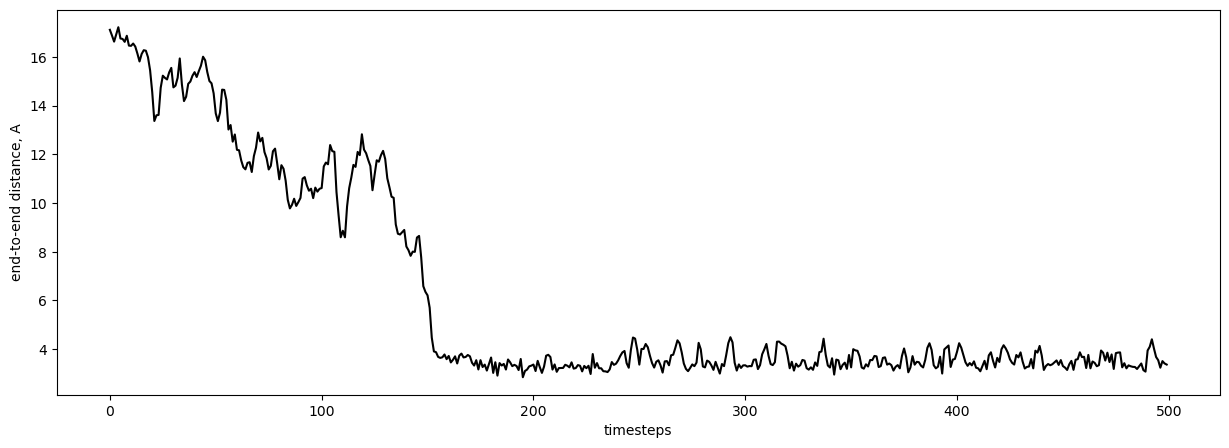

In [9]:
N_terminus = u.select_atoms('resid 1 and name N')
C_terminus = u.select_atoms('resid 5 and name C')

## go through the whole trajectory and compute distance between them for every frame
dist = []
for frame in u.trajectory:
    dist.append(np.linalg.norm(N_terminus.positions - C_terminus.positions))

## the result is in the dist array    
dist = np.array(dist)
plt.figure(figsize=(15,5))

plt.plot( dist, '-k' )
plt.xlabel('timesteps')
plt.ylabel('end-to-end distance, A')

plt.show()


/Users/jerrykwan/anaconda3/envs/temp/lib/python3.9/site-packages/MDAnalysis/analysis/dihedrals.py:422: UserWarning: Cannot determine phi and psi angles for the first or last residues
  warnings.warn("Cannot determine phi and psi angles for the first "


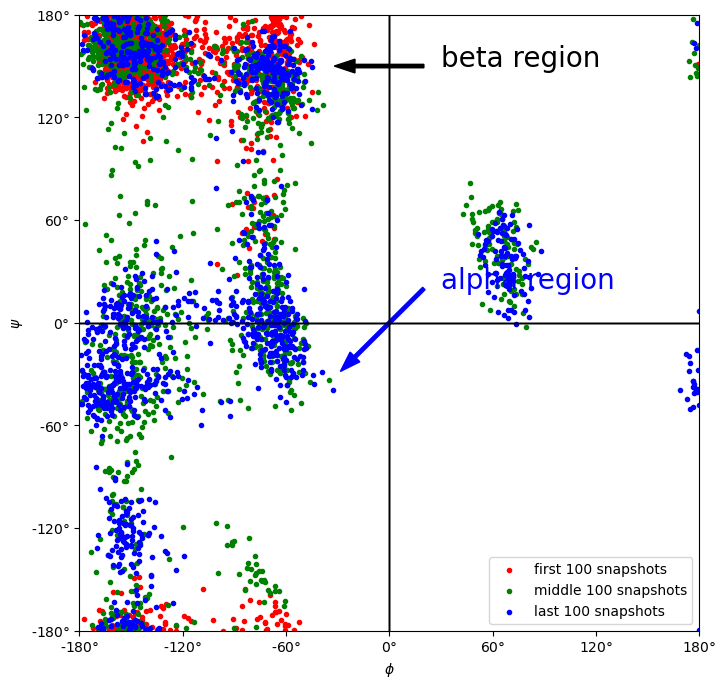

In [10]:
ram1 = dihedrals.Ramachandran(u).run(0, 100) 
ram_mid = dihedrals.Ramachandran(u).run(200, 300)
ram2 = dihedrals.Ramachandran(u).run(400, 500) 

## ramachandran plot
fig, ax = plt.subplots(figsize=(8,8))
ram1.plot(ax=ax, color='r', marker='.', label='first 100 snapshots')
ram_mid.plot(ax=ax, color='g', marker='.', label='middle 100 snapshots')
ram2.plot(ax=ax, color='b', marker='.', label='last 100 snapshots')
ax.arrow(20, 20, -40, -40, width=2, head_width=8, head_length=12, fc='b', ec='b')
ax.text(30, 20, 'alpha region', color='blue', fontsize=20)
ax.arrow(20, 150, -40, 0, width=2, head_width=8, head_length=12, fc='k', ec='k')
ax.text(30, 150, 'beta region', fontsize=20)
plt.legend()
plt.show()